<center><h1> Multi radar clutter analysis </h1></center>

In [1]:
import pyart
import os
import numpy as np
from matplotlib import pyplot as plt
import netCDF4  
from IPython.parallel import Client

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/scollis/anaconda/envs/kazrtools/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [53]:
def granule(arg_dict):
    import imp
    kazr_tools = imp.load_source('kazr_tools', '/home/scollis/projects/kazr_tools/code/kazr_tools.py')
    
    in_file = arg_dict['filename']
    log_dir = '/data/radar/output/'
    odir = '/data/radar/oli_kazr_proc/'
    logfilename = os.path.join(log_dir, in_file.split('/')[-1]+'.log')
    ofilename = os.path.join(odir, in_file.split('/')[-1]+'.processed.nc')
    
    fh = open(logfilename, 'w')
    
    fh.write('opening \n')
    radar = pyart.io.read(in_file, delay_field_loading=True)
    fh.write('calculating \n')
    units = radar.time['units']
    times = num2date(radar.time['data'], units)
    
    toa_bg =  kazr_tools.snr_toa(radar)
    all_mean =  kazr_tools.mean_snr(radar)
    ns, ms, mb = kazr_tools.describe_radar_texture(radar)
    nsc, msc, mbc = kazr_tools.describe_radar_corl(radar, level=0.8)
    radar_snr = radar.fields['snr_copol']['data']
    radar_z = radar.fields['reflectivity']['data']
    radar_v = radar.fields['mean_doppler_velocity']['data']
    radar_t = radar.fields['velocity_texture']['data']
    range_r = radar.range['data']
    radar_corl = radar.fields['co_to_crosspol_correlation_coeff']['data']
    
    min_snr = radar_snr.min(axis=0)
    min_z = radar_z.min(axis=0)
    where_no_clouds_ns = ns < 50
    where_no_clouds_ms = ms < -5
    
    where_no_clouds_cf20 = mbc < -20
    where_no_clouds_cf22 = mbc < -22
    where_no_clouds_cf25 = mbc < -25
    
    mean_snr_ns = radar_snr[where_no_clouds_ns, :].mean(axis=0)
    mean_snr_ms = radar_snr[where_no_clouds_ms, :].mean(axis=0)
    mean_z_ns = radar_z[where_no_clouds_ns, :].mean(axis=0)
    mean_z_ms = radar_z[where_no_clouds_ms, :].mean(axis=0)
    mean_v_ns = radar_v[where_no_clouds_ns, :].mean(axis=0)
    mean_v_ms = radar_v[where_no_clouds_ms, :].mean(axis=0)
    mean_snr_corl20 = radar_snr[where_no_clouds_cf20, :].mean(axis=0)
    mean_snr_corl22 = radar_snr[where_no_clouds_cf22, :].mean(axis=0)
    mean_snr_corl25 = radar_snr[where_no_clouds_cf25, :].mean(axis=0)
    
    #pyart.io.write_cfradial(ofilename, radar)
    
    del(radar, radar_z, radar_v, radar_t, radar_snr)
    tpl = (units, all_mean, toa_bg, 
           times, ns, ms, mb,range_r, 
           mean_snr_ns, mean_snr_ms, mean_z_ns,
           mean_z_ms, mean_v_ns, mean_v_ms, min_snr,
          min_z, nsc, msc, mbc, mean_snr_corl20,
          mean_snr_corl22, mean_snr_corl25)
    fh.write('done \n')
    gc.collect()
    
    return tpl
    

In [27]:
in_dir = '/data/radar/oli_kazr_proc/'
all_files = os.listdir(in_dir)
good_files = []
for fil in all_files:
    if '.nc' in fil:
        good_files.append(fil)
good_files.sort()

In [28]:
print(len(good_files))

399


In [29]:
packing = []
for fn in good_files:
    this_rec = {'filename' : os.path.join(in_dir, fn)}
    packing.append(this_rec)

In [54]:
My_Cluster = Client()
My_View = My_Cluster[:]
print(My_View)
print(len(My_View))

<DirectView [0, 1, 2, 3,...]>
40


In [55]:
My_View.block = False
My_View.execute('import matplotlib')
My_View.execute('matplotlib.use("agg")')
My_View.execute('import pyart')
My_View.execute('import numpy as np')
My_View.execute('import os')
My_View.execute('from netCDF4 import num2date')
My_View.execute('import gc')




result = My_View.map_async(granule, packing)
qvps = result.get()

In [12]:
times = np.array([item[0] for item in  qvps])
alls = np.array([item[1] for item in  qvps])
toas = np.array([item[2] for item in  qvps])
tarrrs = np.array([item[3] for item in  qvps])
ns = np.array([item[4] for item in  qvps])
ms = np.array([item[5] for item in  qvps])
mb = np.array([item[6] for item in  qvps])
nsc = np.array([item[16] for item in  qvps])
msc = np.array([item[17] for item in  qvps])
mbc = np.array([item[18] for item in  qvps])


In [13]:
order = np.argsort(times)

In [14]:
time_array = np.array([netCDF4.num2date(0, units = sstr) for sstr in times[order]])

In [15]:
alls_o = np.concatenate(alls[order])
toas_o = np.concatenate(toas[order])
tarrs_o = np.concatenate(tarrrs[order])
ns_o = np.concatenate(ns[order])
ms_o = np.concatenate(ms[order])
mb_o = np.concatenate(mb[order])
nsc_o = np.concatenate(nsc[order])
msc_o = np.concatenate(msc[order])
mbc_o = np.concatenate(mbc[order])


In [66]:
print(alls_o)

[-17.48135948 -17.51311874 -17.55259132 ..., -18.33920288 -18.23192024
 -18.03085518]


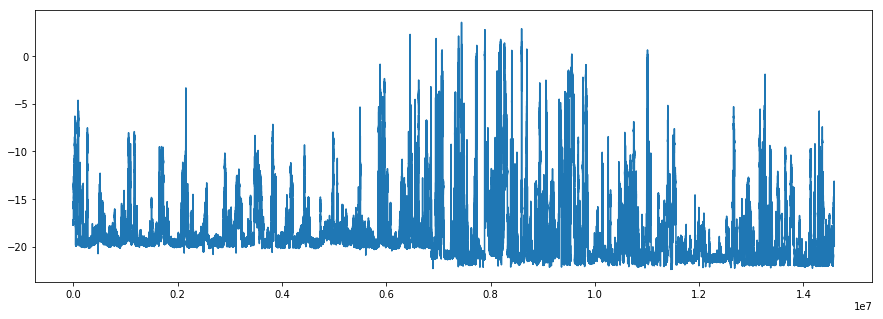

In [67]:
fig = plt.figure(figsize = [15,5])
plt.plot(alls_o)

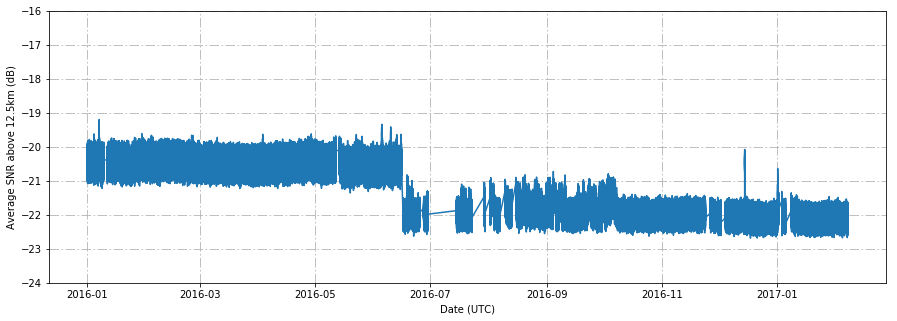

In [68]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, toas_o)
plt.ylim([-24,-16])

ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.ylabel('Average SNR above 12.5km (dB)')
plt.xlabel('Date (UTC)')

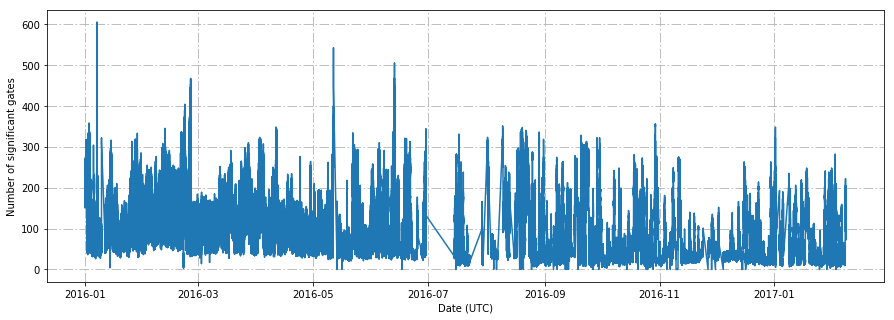

In [69]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, ns_o)
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

#plt.ylim([-24,-20])
plt.ylabel('Number of significant gates')
plt.xlabel('Date (UTC)')

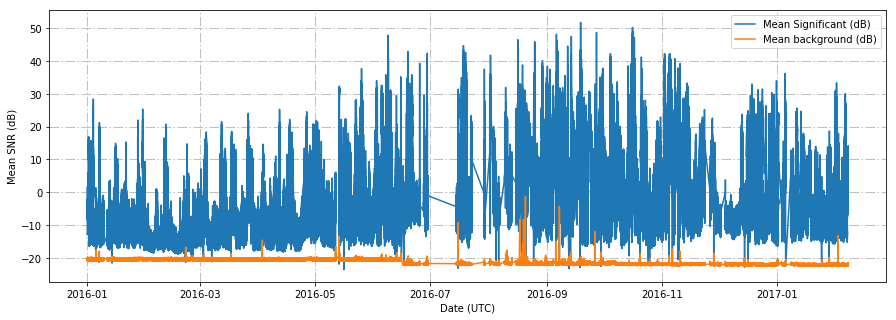

In [70]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, ms_o, label='Mean Significant (dB)')
plt.plot(tarrs_o, mb_o, label='Mean background (dB)')
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.legend()
#plt.ylim([-24,-20])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

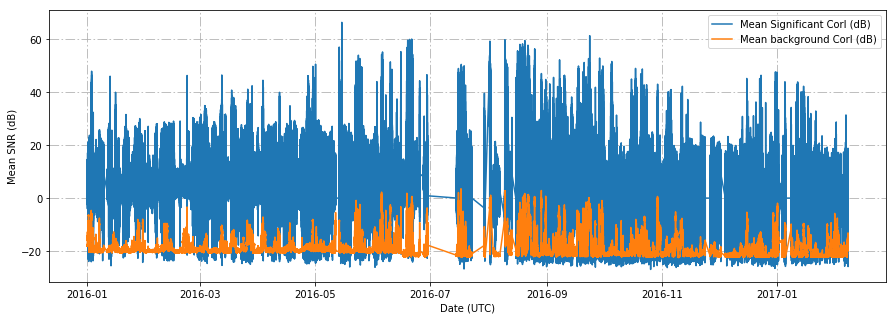

In [16]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, msc_o, label='Mean Significant Corl (dB)')
plt.plot(tarrs_o, mbc_o, label='Mean background Corl (dB)')
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.legend()
#plt.ylim([-24,-20])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

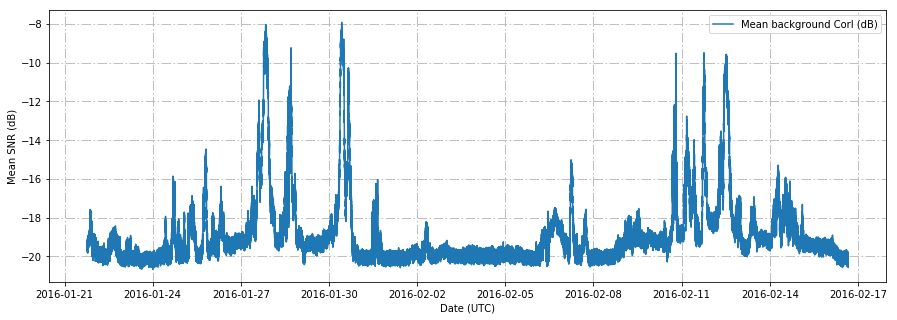

In [22]:
i1 = 1800000
i2 = 3900000
fig = plt.figure(figsize = [15,5])
#plt.plot(tarrs_o[i1:i2], msc_o[i1:i2], label='Mean Significant Corl (dB)')
plt.plot(tarrs_o[i1:i2], mbc_o[i1:i2], label='Mean background Corl (dB)')
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.legend()
#plt.ylim([-24,-20])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

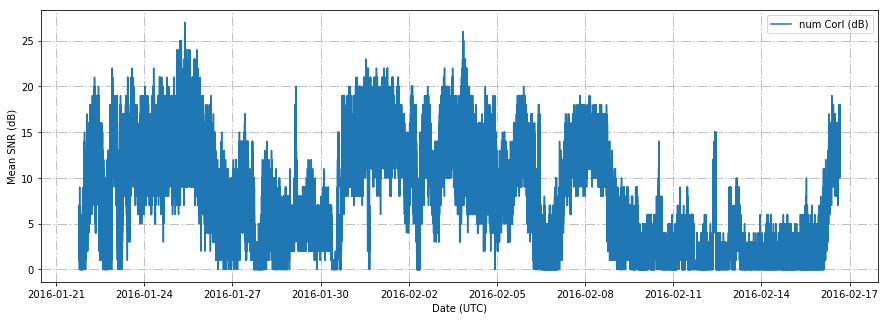

In [25]:
i1 = 800000
i2 = 1900000
fig = plt.figure(figsize = [15,5])
#plt.plot(tarrs_o[i1:i2], msc_o[i1:i2], label='Mean Significant Corl (dB)')
plt.plot(tarrs_o[i1:i2], nsc_o[i1:i2], label='num Corl (dB)')
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.legend()
#plt.ylim([-24,-20])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

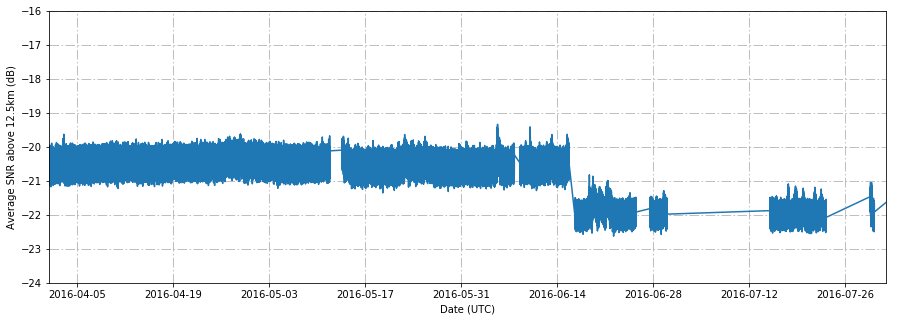

In [71]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, toas_o)
plt.ylim([-24,-16])
plt.xlim([netCDF4.datetime(2016, 4, 1,), netCDF4.datetime(2016, 8, 1,)])
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.ylabel('Average SNR above 12.5km (dB)')
plt.xlabel('Date (UTC)')

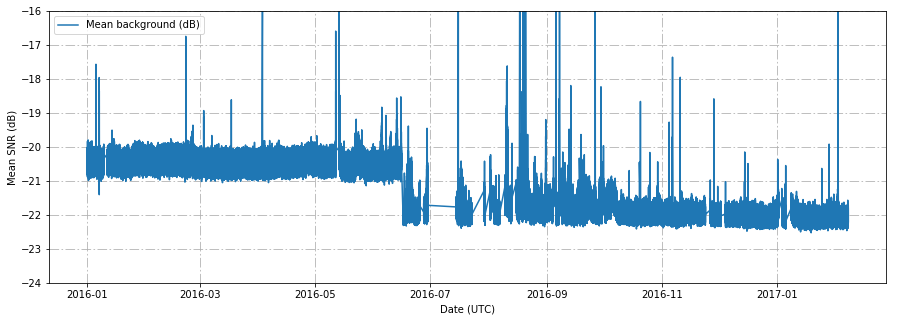

In [72]:
fig = plt.figure(figsize = [15,5])
#plt.plot(tarrs_o, ms_o, label='Mean Significant (dB)')
plt.plot(tarrs_o, mb_o, label='Mean background (dB)')
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')

plt.legend()
plt.ylim([-24,-16])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

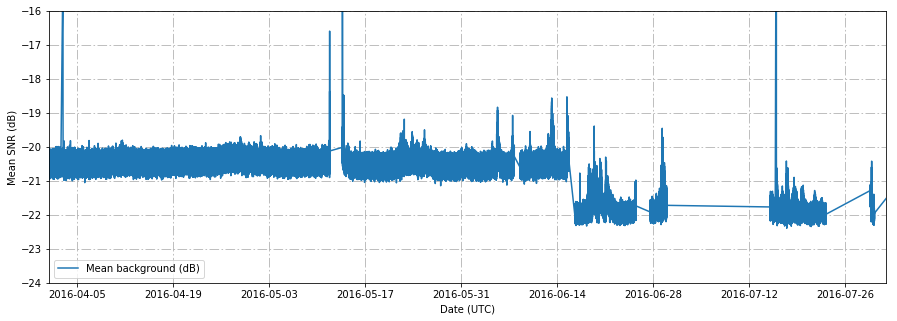

In [73]:
fig = plt.figure(figsize = [15,5])
#plt.plot(tarrs_o, ms_o, label='Mean Significant (dB)')
plt.plot(tarrs_o, mb_o, label='Mean background (dB)')
plt.xlim([netCDF4.datetime(2016, 4, 1,), netCDF4.datetime(2016, 8, 1,)])
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')


plt.legend()
plt.ylim([-24,-16])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

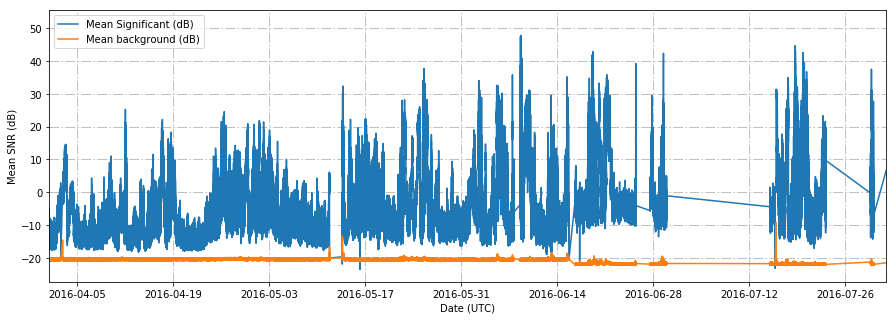

In [74]:
fig = plt.figure(figsize = [15,5])
plt.plot(tarrs_o, ms_o, label='Mean Significant (dB)')
plt.plot(tarrs_o, mb_o, label='Mean background (dB)')
plt.xlim([netCDF4.datetime(2016, 4, 1,), netCDF4.datetime(2016, 8, 1,)])
ax = plt.gca()
ax.grid(True)

gridlines = ax.get_xgridlines() + ax.get_ygridlines()

for line in gridlines:
    line.set_linestyle('-.')


plt.legend()
#plt.ylim([-24,-20])
plt.ylabel('Mean SNR (dB)')
plt.xlabel('Date (UTC)')

In [75]:
#tpl = (units, all_mean, toa_bg, 
#           times, ns, ms, mb, range_r, 
#           mean_snr_ns, mean_snr_ms, mean_z_ns,
#           mean_z_ms, mean_v_ns, mean_v_ms, min_snr,
#          min_z)

In [61]:
locations = {'range': 7, 'mean_snr_ns' : 8, 'mean_snr_ms' : 9, 'mean_z_ns' : 10,
             'mean_z_ms' : 11, 'mean_v_ns' : 12, 'mean_v_ms' : 13, 'min_snr' : 14,
             'min_z' : 15, 'mean_snr_corl20' :19, 'mean_snr_corl22' :20,
             'mean_snr_corl25' :21}

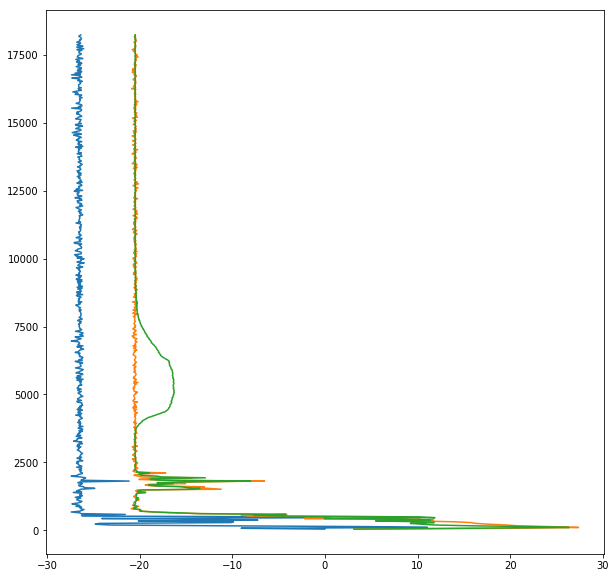

In [62]:
test_index = 101
fig = plt.figure(figsize = [10,10])
plt.plot(qvps[test_index][locations['min_snr']],qvps[test_index][locations['range']] )

plt.plot(qvps[test_index][locations['mean_snr_ns']],qvps[test_index][locations['range']] )
plt.plot(qvps[test_index][locations['mean_snr_ms']],qvps[test_index][locations['range']] )



In [63]:
th_series = {}
for key in locations.keys():
    if key is not 'range':
        th_series.update({key: np.ma.empty([len(qvps), len(qvps[0][locations['range']])])})

In [64]:
for profile_number in range(len(qvps)):
    print(profile_number)
    print(qvps[profile_number][0])
    n_gates = len(qvps[profile_number][locations['range']])
    print(n_gates) #needed to cludge given change in gates
    for key in th_series.keys():
        th_series[key][profile_number, 0:n_gates] = np.ma.masked_invalid(qvps[profile_number][locations[key]])



0
seconds since 2016-01-01 00:00:00 0:00
608
1
seconds since 2016-01-02 00:00:00 0:00
608
2
seconds since 2016-01-03 00:00:00 0:00
608
3
seconds since 2016-01-04 00:00:00 0:00
608
4
seconds since 2016-01-05 00:00:00 0:00
608
5
seconds since 2016-01-06 00:00:00 0:00
608
6
seconds since 2016-01-07 00:00:00 0:00
608
7
seconds since 2016-01-08 00:00:00 0:00
608
8
seconds since 2016-01-09 00:00:00 0:00
608
9
seconds since 2016-01-11 00:00:00 0:00
608
10
seconds since 2016-01-12 00:00:00 0:00
608
11
seconds since 2016-01-13 00:00:00 0:00
608
12
seconds since 2016-01-14 00:00:00 0:00
608
13
seconds since 2016-01-15 00:00:00 0:00
608
14
seconds since 2016-01-15 00:00:00 0:00
608
15
seconds since 2016-01-16 00:00:00 0:00
608
16
seconds since 2016-01-17 00:00:00 0:00
608
17
seconds since 2016-01-18 00:00:00 0:00
608
18
seconds since 2016-01-19 00:00:00 0:00
608
19
seconds since 2016-01-20 00:00:00 0:00
608
20
seconds since 2016-01-21 00:00:00 0:00
608
21
seconds since 2016-01-22 00:00:00 0:00
60

In [50]:
units_array = np.array([netCDF4.num2date(0, qvps[i][0]) for i in range(len(qvps))])

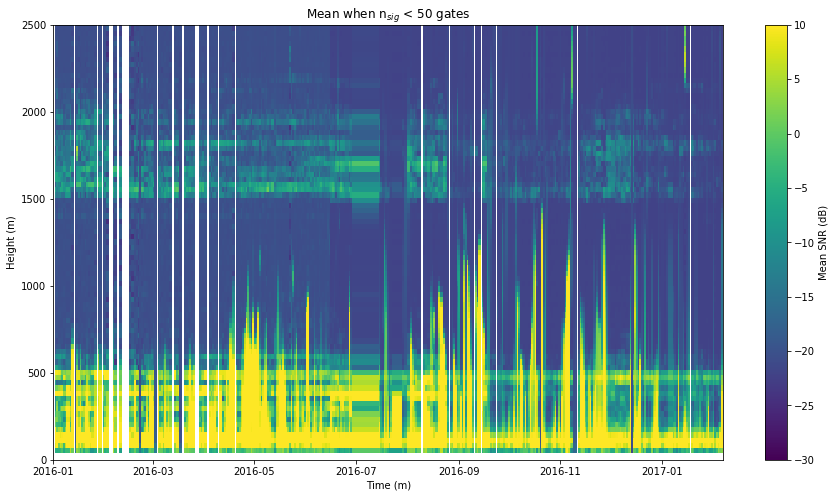

In [38]:
fig = plt.figure(figsize=[15,8])
plt.pcolormesh(units_array, qvps[0][locations['range']], th_series['mean_snr_ns'].transpose(),
              vmin =-30, vmax = 10)
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Time (m)')
plt.title(r'Mean when n$_{sig}$ < 50 gates')
cb = plt.colorbar()
cb.set_label('Mean SNR (dB)')
plt.savefig('../images/mean_in_day_snr_ns.png')


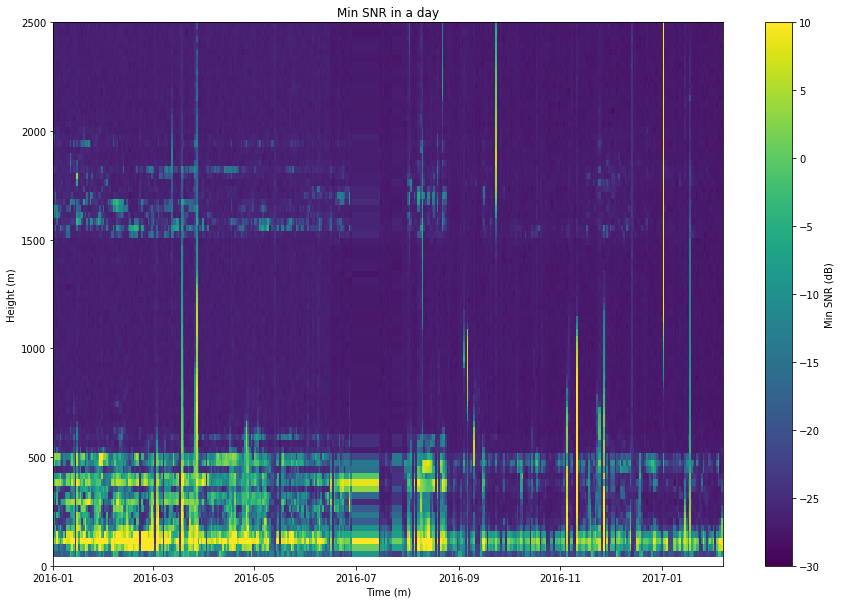

In [40]:
fig = plt.figure(figsize=[15,10])
plt.pcolormesh(units_array, qvps[0][locations['range']], th_series['min_snr'].transpose(),
              vmin =-30, vmax = 10)
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Time (m)')
plt.title(r'Min SNR in a day')
cb = plt.colorbar()
cb.set_label('Min SNR (dB)')
plt.savefig('../images/min_in_day_snr.png')

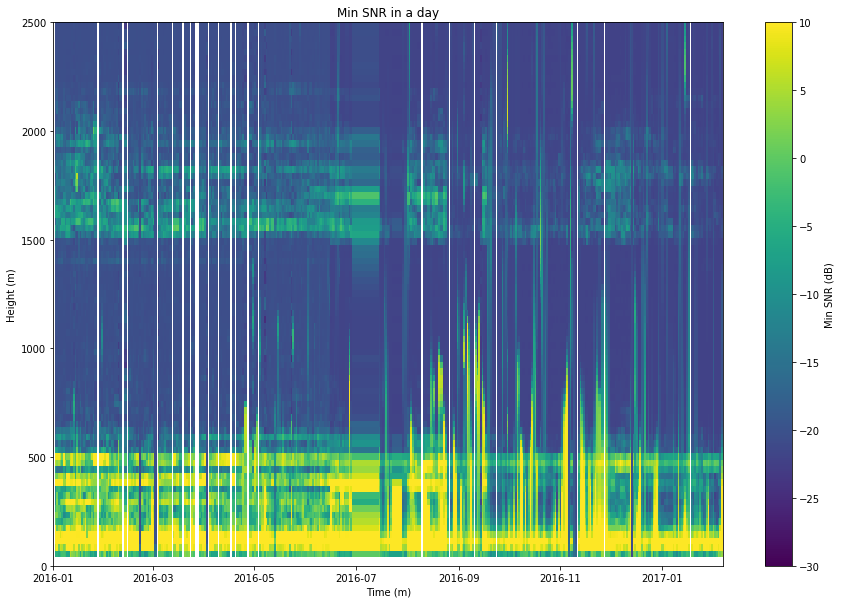

In [65]:
fig = plt.figure(figsize=[15,10])
plt.pcolormesh(units_array, qvps[0][locations['range']], th_series['mean_snr_corl20'].transpose(),
              vmin =-30, vmax = 10)
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Time (m)')
plt.title(r'Min SNR in a day')
cb = plt.colorbar()
cb.set_label('Min SNR (dB)')
plt.savefig('../images/mean_snr_corl20.png')

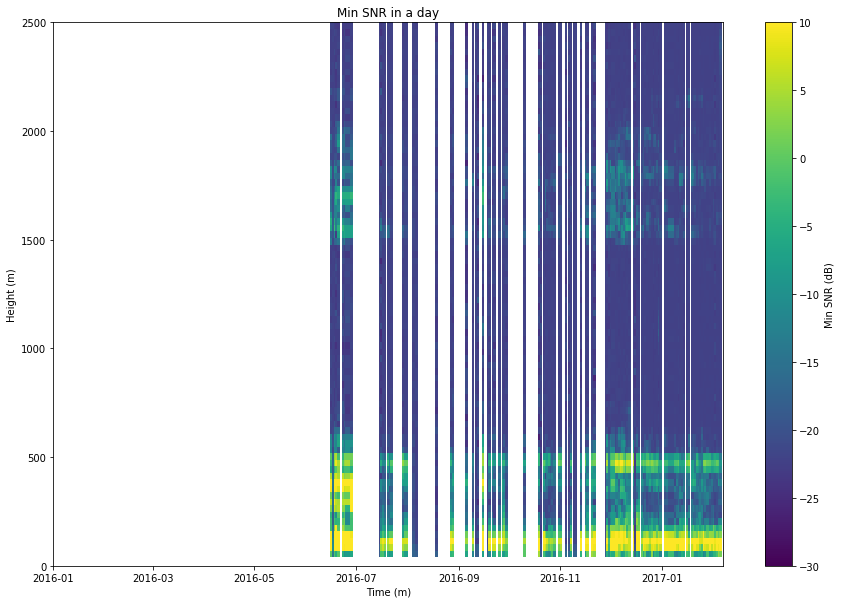

In [68]:
fig = plt.figure(figsize=[15,10])
plt.pcolormesh(units_array, qvps[0][locations['range']], th_series['mean_snr_corl22'].transpose(),
              vmin =-30, vmax = 10)
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Time (m)')
plt.title(r'Min SNR in a day')
cb = plt.colorbar()
cb.set_label('Min SNR (dB)')
plt.savefig('../images/mean_snr_corl22.png')

In [70]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


In [71]:
shroud_date = netCDF4.datetime(2016, 8, 24, 0,0,)
shroud_idx = find_nearest(units_array, shroud_date)


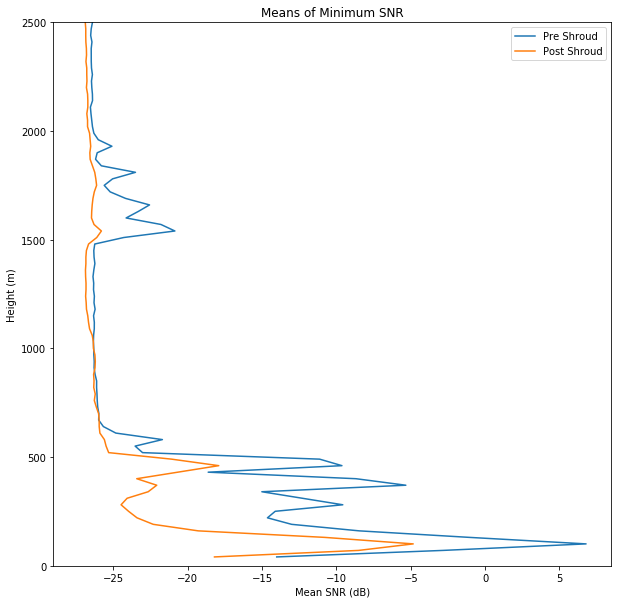

In [85]:
mins_pre_shroud = th_series['min_snr'][0:shroud_idx, :].mean(axis=0)
mins_post_shroud = th_series['min_snr'][shroud_idx::, :].mean(axis=0)

fig = plt.figure(figsize = [10,10])
plt.plot(mins_pre_shroud,qvps[test_index][locations['range']], label='Pre Shroud' )
plt.plot(mins_post_shroud,qvps[test_index][locations['range']], label='Post Shroud' )
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Mean SNR (dB)')
plt.title('Means of Minimum SNR')
plt.legend()
plt.savefig('../images/diff_min.png')


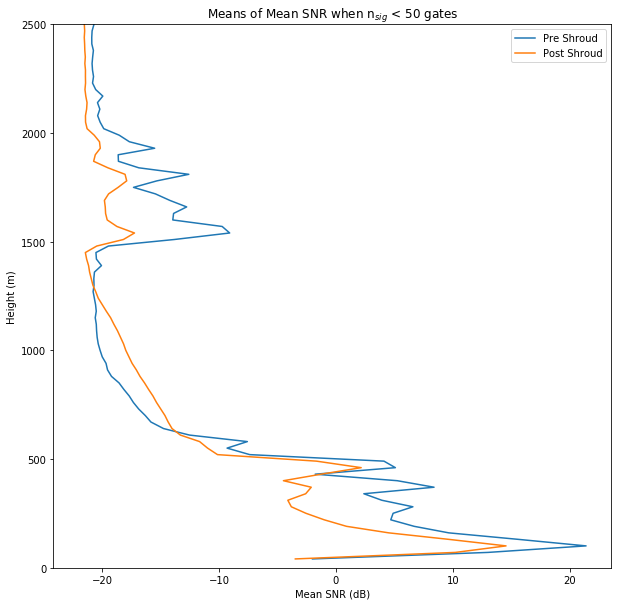

In [86]:
mean_ns_pre_shroud = th_series['mean_snr_ns'][0:shroud_idx, :].mean(axis=0)
mean_ns_post_shroud = th_series['mean_snr_ns'][shroud_idx::, :].mean(axis=0)

fig = plt.figure(figsize = [10,10])
plt.plot(mean_ns_pre_shroud,qvps[test_index][locations['range']], label='Pre Shroud' )
plt.plot(mean_ns_post_shroud,qvps[test_index][locations['range']], label='Post Shroud' )
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Mean SNR (dB)')
plt.title(r'Means of Mean SNR when n$_{sig}$ < 50 gates')
plt.legend()
plt.savefig('../images/diff_mean_ns.png')



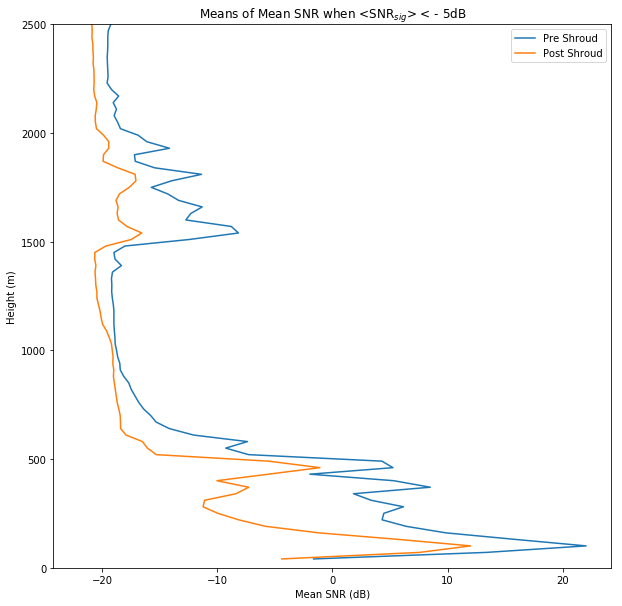

In [87]:
mean_ms_pre_shroud = th_series['mean_snr_ms'][0:shroud_idx, :].mean(axis=0)
mean_ms_post_shroud = th_series['mean_snr_ms'][shroud_idx::, :].mean(axis=0)

fig = plt.figure(figsize = [10,10])
plt.plot(mean_ms_pre_shroud,qvps[test_index][locations['range']], label='Pre Shroud' )
plt.plot(mean_ms_post_shroud,qvps[test_index][locations['range']], label='Post Shroud' )
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Mean SNR (dB)')
plt.title(r'Means of Mean SNR when <SNR$_{sig}$> < - 5dB')
plt.legend()
plt.savefig('../images/diff_mean_ms.png')


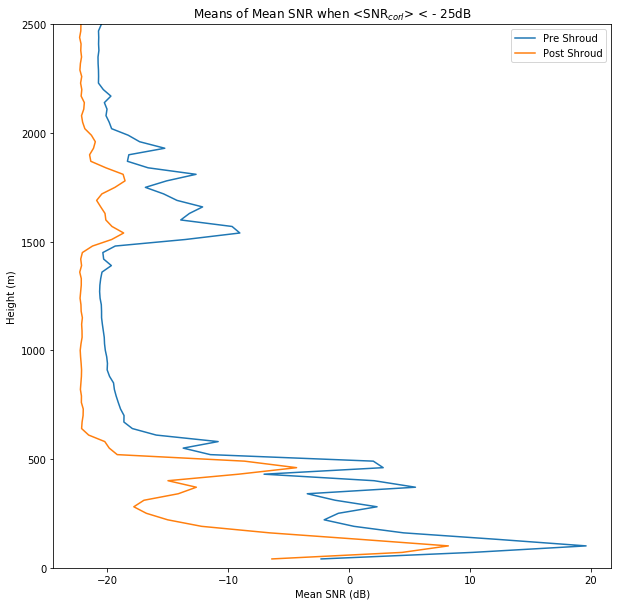

In [72]:
mean_ms_pre_shroud = th_series['mean_snr_corl20'][0:shroud_idx, :].mean(axis=0)
mean_ms_post_shroud = th_series['mean_snr_corl22'][shroud_idx::, :].mean(axis=0)

fig = plt.figure(figsize = [10,10])
plt.plot(mean_ms_pre_shroud,qvps[test_index][locations['range']], label='Pre Shroud' )
plt.plot(mean_ms_post_shroud,qvps[test_index][locations['range']], label='Post Shroud' )
plt.ylim([0, 2500])
plt.ylabel('Height (m)')
plt.xlabel('Mean SNR (dB)')
plt.title(r'Means of Mean SNR when <SNR$_{corl}$> < - 25dB')
plt.legend()
plt.savefig('../images/diff_mean_corl.png')


In [88]:
import pickle
with open('/home/scollis/oli_kazr.pk', 'wb') as output:
    pickle.dump(qvps, output)
